# Roman configurations

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import corner
from slsim.image_simulation import point_source_coordinate_properties
from slsim.Plots.plot_functions import create_image_montage_from_image_list
from slsim.roman_image_simulation import lens_image_roman

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## Supernovae population for the Roman survey
In this notebook, we simulate population of lensed supernovae for the Roman survey and simulate image of a 

random lensed supernovae. It follows following steps:

1. Simulate lensed supernovae population
2. Choose a lens at random
3. Set observation time and other image configuration
4. Simulate image of a selected lens
5. Visualize it

Before running this notebook, please download the download psfs from cached_webb_psf
(https://github.com/LSST-strong-lensing/data_public/webbpsf), where the
psfs have been generated ahead of time so that they can be loaded from a file.

## Set Roman configurations

In [ ]:
# Import default Roman Space Telescope configuration
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/roman-like.yml")

# generate Roman filters
configure_roman_filters()

# import filter bands and make them recogniable in speclite
roman_filters = filter_names()
# filters are ['Roman-F062', 'Roman-F087', 'Roman-F106', 'Roman-F129', 'Roman-F158', 'Roman-F184', 'Roman-F146', 'Roman-F213']

speclite.filters.load_filters(
    roman_filters[0],
    roman_filters[1],
    roman_filters[2],
    roman_filters[3],
    roman_filters[4],
    roman_filters[5],
    roman_filters[6],
    roman_filters[7],
)

## Simulate lensed supernovae population

In [ ]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
deflector_sky_area = Quantity(value=10, unit="deg2")
source_sky_area = Quantity(value=10, unit="deg2")
sky_area = Quantity(value=1000, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F062", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"z_min": 0.01, "z_max": 5}

time_range = np.linspace(-50, 500, 550)
modeldir = "/Users/narayankhadka/Downloads/sncosmo_sn_models/SALT3.NIR_WAVEEXT/"

In [ ]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config, sky_area=deflector_sky_area, filters=None, cosmo=cosmo
)

In [ ]:
# Initiate deflector population class
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=deflector_sky_area,
)

/Users/narayankhadka/slsim/slsim/Deflectors/elliptical_lens_galaxies.py:46: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


In [ ]:
# generate supernovae population
supernovae_catalog = sources.SupernovaeCatalog.SupernovaeCatalog(
    sn_type="Ia",
    band_list=["F184", "F129", "F062"],
    lightcurve_time=time_range,
    absolute_mag_band="bessellb",
    absolute_mag=None,
    mag_zpsys="ab",
    cosmo=cosmo,
    skypy_config=skypy_config,
    sky_area=source_sky_area,
    host_galaxy_candidate=galaxy_simulation_pipeline.blue_galaxies,
)
supernovae_data = supernovae_catalog.supernovae_catalog(
    host_galaxy=True, lightcurve=False
)

/Users/narayankhadka/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numerator = integrate.quad(
/Users/narayankhadka/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = integrate.quad(
/Users/narayankhadka/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  numerator = int

In [ ]:
kwargs_sn = {
    "variability_model": "light_curve",
    "kwargs_variability": {"supernovae_lightcurve", "F184", "F129", "F062"},
    "sn_type": "Ia",
    "sn_absolute_mag_band": "bessellb",
    "sn_absolute_zpsys": "ab",
    "lightcurve_time": np.linspace(-50, 100, 150),
    "sn_modeldir": None,
}

In [ ]:
source_SNIa = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=supernovae_data,
    cosmo=cosmo,
    sky_area=source_sky_area,
    kwargs_cut={},
    catalog_type="skypy",
    source_size=None,
)

In [ ]:
# Initiate LensPop class
lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_SNIa,
    cosmo=cosmo,
    sky_area=sky_area,
)

In [ ]:
# Draw lens population
kwargs_lens_cut = {"min_image_separation": 0.5, "max_image_separation": 10}
lens_population = lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut, speed_factor=10
)

In [ ]:
print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = min(gg_lens.point_source_magnitude(band="F129", lensed=True)[0])
    deflector_mag = gg_lens.deflector_magnitude(band="F129")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 1115


/Users/narayankhadka/slsim/slsim/Sources/supernovae.py:114: UserWarning: bandpass 'f062' [4600, .., 7900] outside spectral range [7789.38, .., 77893.8]
Ignoring bandpass for now. Use extended wavelength SN models found here: https://github.com/LSST-strong-lensing/data_public/tree/main/sncosmo_sn_models
  warn(
/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/narayankhadka/slsim/slsim/Sources/supernovae.py:114: UserWarning: bandpass 'f062' [4600, .., 7900] outside spectral range [8694.95, .., 86949.5]
Ignoring bandpass for now. Use extended wavelength SN models found here: https://github.com/LSST-strong-lensing/data_public/tree/main/sncosmo_sn_models
  warn(
/Users/narayankhadka/slsim/slsim/Sources/supernovae.py:114: UserWarning: bandpass 'f062' [4600, .., 7900] outside spectral range [8569.87, .., 85698.7]
Ignoring bandpass for now. Use extended wavelength SN models found 

In [ ]:
## clean the population. It removes supernovae with nan value for magnitude.
lens_samples = np.array(lens_samples)
cleaned_data = lens_samples[~np.isnan(lens_samples).any(axis=1)]

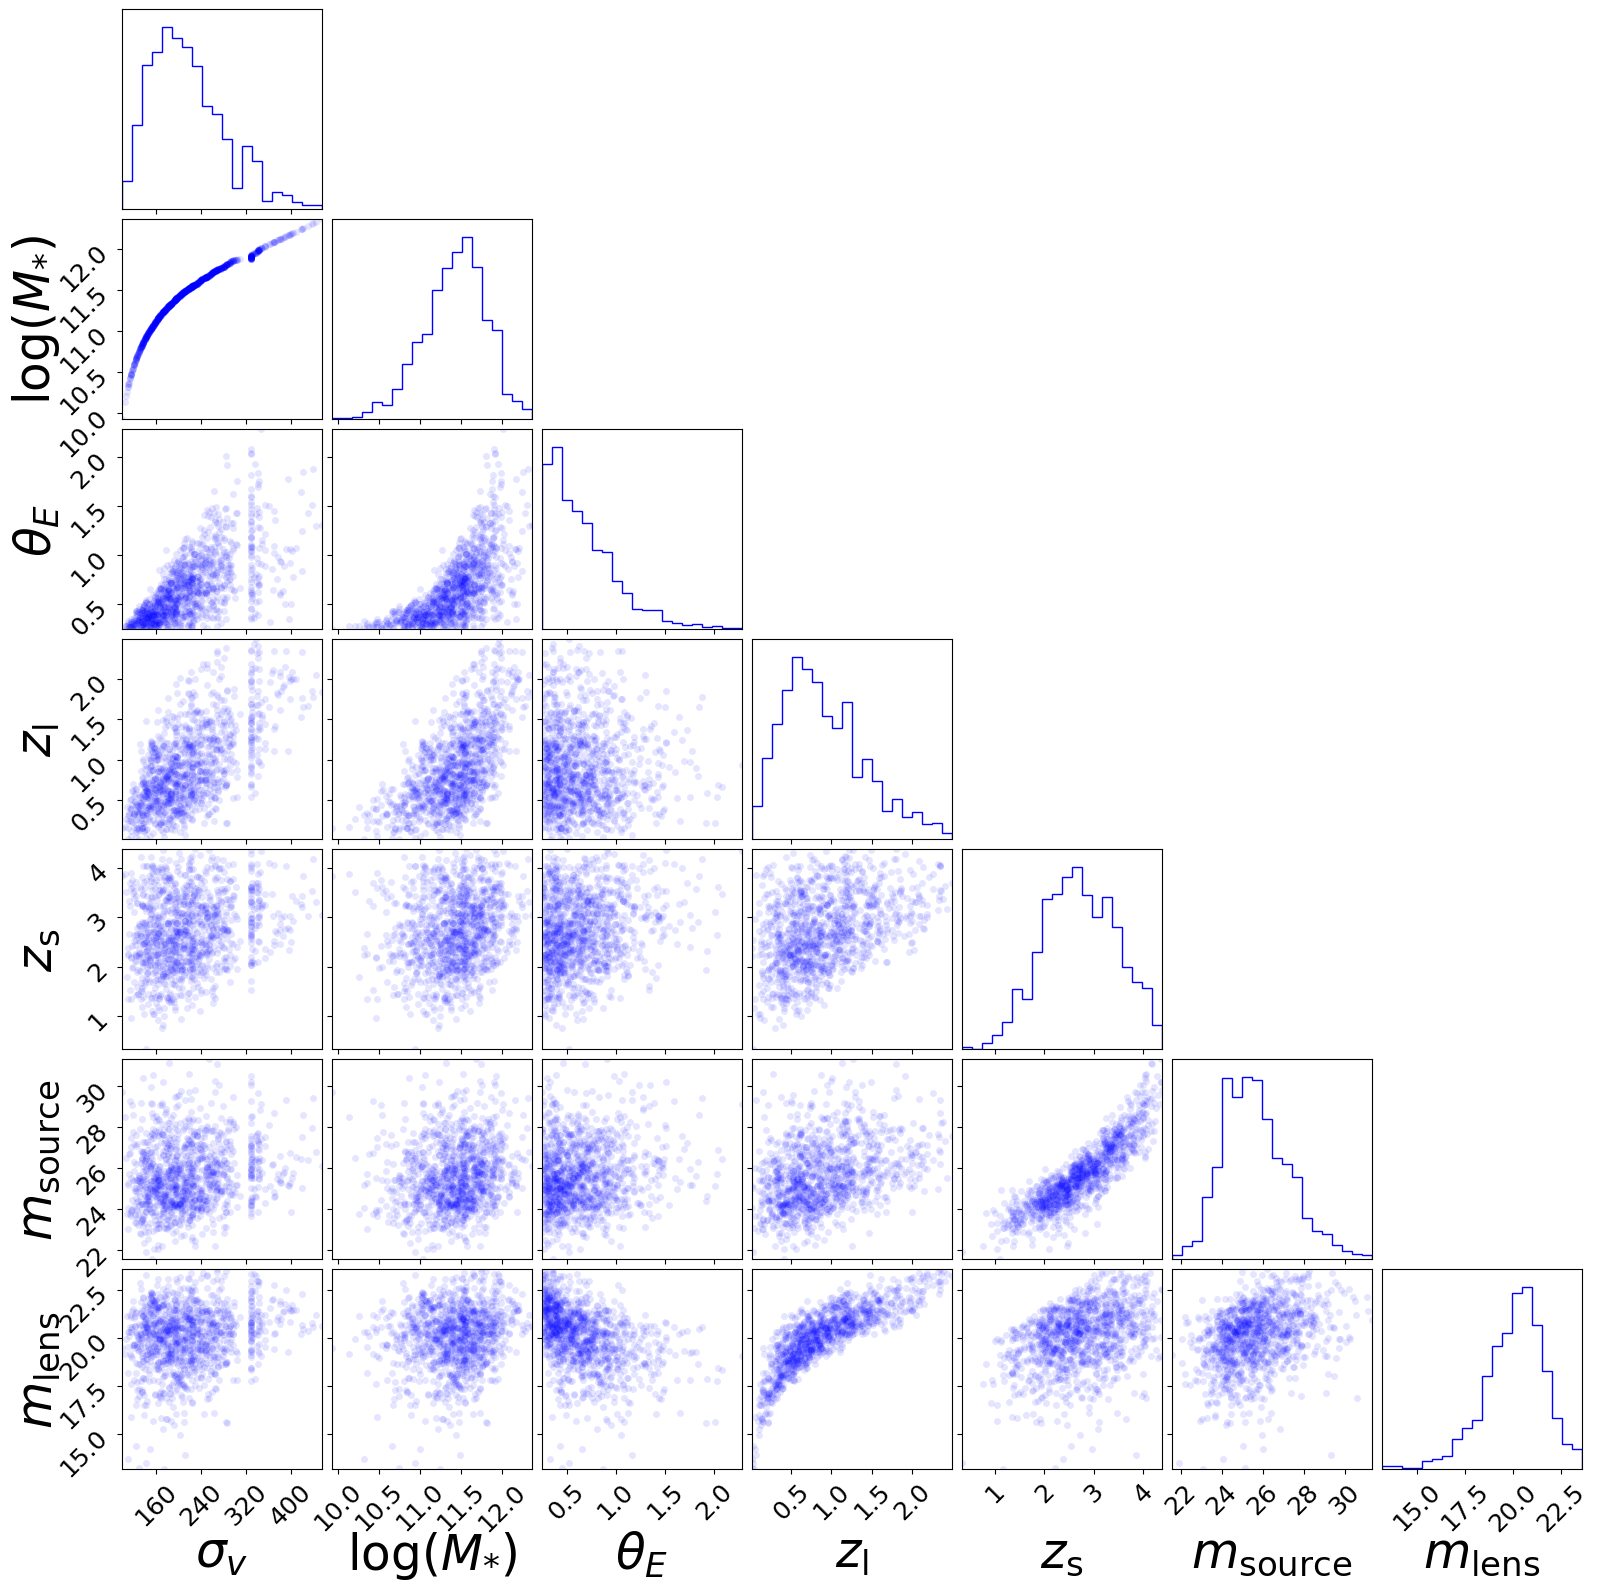

In [ ]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(cleaned_data), labels=labels, **hist2dkwargs)
plt.show()

## Choose a random lens

In [ ]:
lens_class = lens_population[178]

This is a type Ia SN


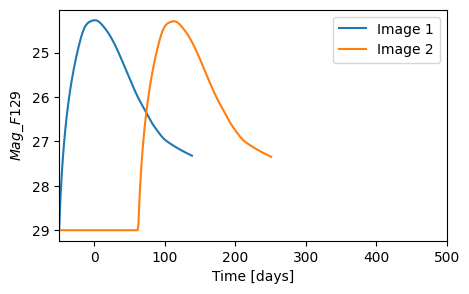

In [ ]:
time = np.linspace(-50, 500, 500)
# light_curve = lens_class_test.source[0].variability_class.kwargs_model

print("This is a type", lens_class.source[0].sn_type, "SN")
magnitude = lens_class.point_source_magnitude(band="F129", lensed=True, time=time)

plt.figure(figsize=(5, 3))
plt.plot(time, magnitude[0][0], label="Image 1")
plt.plot(time, magnitude[0][1], label="Image 2")
plt.gca().invert_yaxis()
plt.ylabel(r"$Mag\_{F129}$")
plt.xlabel("Time [days]")
plt.xlim(-50, 500)
plt.legend()

## Simulate images 

In [ ]:
time = np.array([-25, 0, 50, 80, 90, 100, 125, 150, 200, 250])
time_series_images = []
for t in time:
    image_roman = lens_image_roman(
        lens_class=lens_class,
        band="F129",
        mag_zero_point=27,
        num_pix=71,
        transform_pix2angle=np.array([[0.11, 0], [0, 0.11]]),
        detector=1,
        detector_pos=(2000, 2000),
        oversample=5,
        psf_directory="/Users/narayankhadka/Downloads/cached_webb_psf/",  # replace this path
        # with the path where you have downloaded webbpsf.
        t_obs=t,
        with_source=False,
        with_deflector=False,
        ra=30,
        dec=-30,
        add_noise=True,
        seed=None,
    )
    time_series_images.append(image_roman)

In [ ]:
pix_coord = point_source_coordinate_properties(
    lens_class=lens_class,
    band="F184",
    mag_zero_point=27,
    delta_pix=0.11,
    num_pix=71,
    transform_pix2angle=np.array([[0.11, 0], [0, 0.11]]),
)["image_pix"]

In [ ]:
image_montage = create_image_montage_from_image_list(
    num_rows=3,
    num_cols=5,
    images=time_series_images,
    time=time,
    image_center=pix_coord,
)

'image_montage=create_image_montage_from_image_list(\n    num_rows=3,\n    num_cols=5,\n    images=time_series_images,\n    time=time,\n    image_center=pix_coord,\n)'